In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
import xgboost

pd.options.display.max_columns = None

# 0. Data Preview

The features of the data are mobile phone specifications (Brand, OS, Hardware etc) and the target is the phone's price.

In [2]:
# https://www.kaggle.com/datasets/pratikgarai/mobile-phone-specifications-and-prices/
dtf = pd.read_csv("./ndtv_data_final.csv",index_col='Unnamed: 0')

In [3]:
# convert Yes/No columns to binary 1/0
dtf['Touchscreen']= dtf['Touchscreen'].map(dict(Yes=1, No=0))
dtf['Wi-Fi']= dtf['Wi-Fi'].map(dict(Yes=1, No=0))
dtf['Bluetooth']= dtf['Bluetooth'].map(dict(Yes=1, No=0))
dtf['GPS']= dtf['GPS'].map(dict(Yes=1, No=0))
dtf['3G']= dtf['3G'].map(dict(Yes=1, No=0))
dtf['4G/ LTE']= dtf['4G/ LTE'].map(dict(Yes=1, No=0))
# Price is given in Indian Rupee, convert to USD based on today exchange rate
dtf['Price']= dtf['Price'] * 0.012

In [4]:
# dtf['Android_OS'] = 0
# dtf.loc[dtf['Operating system'] == 'Android', 'Android_OS'] = 1
# dtf['iOS'] = 0
# dtf.loc[dtf['Operating system'] == 'iOS', 'iOS'] = 1


In [5]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1358
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    1359 non-null   object 
 1   Brand                   1359 non-null   object 
 2   Model                   1359 non-null   object 
 3   Battery capacity (mAh)  1359 non-null   int64  
 4   Screen size (inches)    1359 non-null   float64
 5   Touchscreen             1359 non-null   int64  
 6   Resolution x            1359 non-null   int64  
 7   Resolution y            1359 non-null   int64  
 8   Processor               1359 non-null   int64  
 9   RAM (MB)                1359 non-null   int64  
 10  Internal storage (GB)   1359 non-null   float64
 11  Rear camera             1359 non-null   float64
 12  Front camera            1359 non-null   float64
 13  Operating system        1359 non-null   object 
 14  Wi-Fi                   1359 non-null   int64

In [6]:
dtf.head()

,Name,Brand,Model,Battery capacity (mAh),Screen size (inches),Touchscreen,Resolution x,Resolution y,Processor,RAM (MB),Internal storage (GB),Rear camera,Front camera,Operating system,Wi-Fi,Bluetooth,GPS,Number of SIMs,3G,4G/ LTE,Price
0,OnePlus 7T Pro McLaren Edition,OnePlus,7T Pro McLaren Edition,4085,6.67,1,1440,3120,8,12000,256.0,48.0,16.0,Android,1,1,1,2,1,1,707.976
1,Realme X2 Pro,Realme,X2 Pro,4000,6.50,1,1080,2400,8,6000,64.0,64.0,16.0,Android,1,1,1,2,1,1,335.988
2,iPhone 11 Pro Max,Apple,iPhone 11 Pro Max,3969,6.50,1,1242,2688,6,4000,64.0,12.0,12.0,iOS,1,1,1,2,1,1,1282.800
3,iPhone 11,Apple,iPhone 11,3110,6.10,1,828,1792,6,4000,64.0,12.0,12.0,iOS,1,1,1,2,1,1,754.800
4,LG G8X ThinQ,LG,G8X ThinQ,4000,6.40,1,1080,2340,8,6000,128.0,12.0,32.0,Android,1,1,1,1,0,0,599.880


In [7]:
numeric_cols = [x for x in dtf.columns if dtf[x].dtype == 'int64' or dtf[x].dtype == 'float64']

# 1. Error Analysis Conclusions & Work Plan

## Baseline Model Error Analysis

The baseline model has received the following metrics:  
  
r^2 score:0.5226881595128583  
Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 0.478  
Mean Absolute Error (Σ|y - pred|/n): 55  
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 119  
Max Error: 1,391  
  
As discussed in part 1, our r^2 score is pretty low, meaning that the model doesn't "explain" the variance.  
In addition, the mean absolute perc error is significantly high: half (!) of the phone price - which translates to 55 USD at average.  
However, the max error shouldn't worry us too much since we saw that our target variable is skewed with many outliers.  

## Conclusions & Work Plan

1. We saw that many of the hardware features (camera,memory,screen size etc) are highly correlated with each other - therefore they may be redundant and should be removed without sacrificing too much r^2.  
   For comparison we'll be using adjusted r^2 which also takes into account the number of features that are in the model.

Text(0.5, 1.0, 'Diagonal Correlation Matrix')

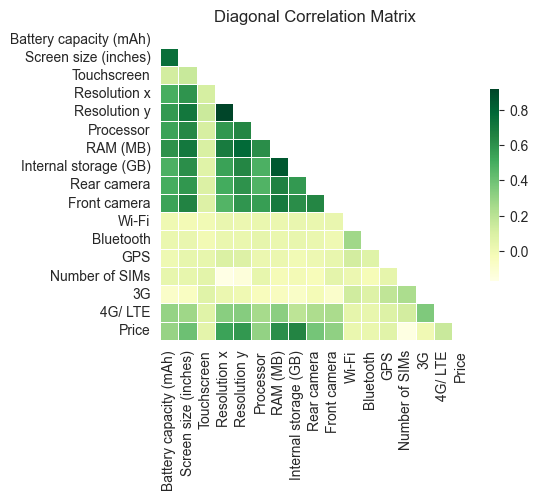

In [8]:
dtf_corr = dtf[numeric_cols].corr()
mask = np.triu(np.ones_like(dtf_corr, dtype=bool))
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(dtf_corr, mask=mask, cmap='YlGn',  square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Diagonal Correlation Matrix")

2. We have found out that our battery size doesn't have high correlation to the target in the raw data, but after correctly binning it there is a correlation (both positive and negative) - therefore some further feature engineering is needed in those cases (more continuous features will be checked for binning aside).  
      For comparison we'll be using adjusted r^2 which also takes into account the number of features that are in the model.

C:\Users\eldor\AppData\Local\Temp\ipykernel_10708\4209431633.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dtf_battery_price = dtf.groupby(pd.cut(dtf['Battery capacity (mAh)'],7))['Price'].mean()
C:\Users\eldor\AppData\Local\Temp\ipykernel_10708\4209431633.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


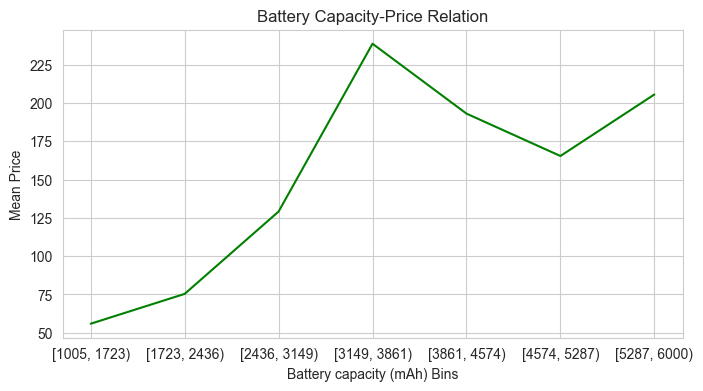

In [9]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,4))
dtf_battery_price = dtf.groupby(pd.cut(dtf['Battery capacity (mAh)'],7))['Price'].mean()
l = dtf_battery_price.index.categories.left.map("{:.0f}".format)
r = dtf_battery_price.index.categories.right.map("{:.0f}".format)
xticklabels = ['0'] + list('['+l+', '+r+')') # adding '0' as a place holder for zero tick label
plt.plot(range(len(dtf_battery_price)), dtf_battery_price.values,color='green')

ax.set_xticklabels(xticklabels)
ax.set_xlabel("Battery capacity (mAh) Bins")
ax.set_ylabel("Mean Price")
ax.set_title("Battery Capacity-Price Relation")

plt.show()

3. In the base model there wasn't any hyper-paramter tuning - an hyper parameters grid search will be applied

# 2. Improving Model Performance

In [10]:
# dtf for comparing models' results
results_dtf = pd.DataFrame(columns=['model','r2','adj_r2','Mean Absolute Perc Error','Mean Absolute Error','Root Mean Squared Error','Max Error'])

## Baseline Pipeline (based on the previous submission)

In [11]:
# train/test split
dtf_train, dtf_test = train_test_split(dtf, test_size=0.25,random_state=10)

Text(0.5, 1.0, 'Battery Capacity-Price Relation')

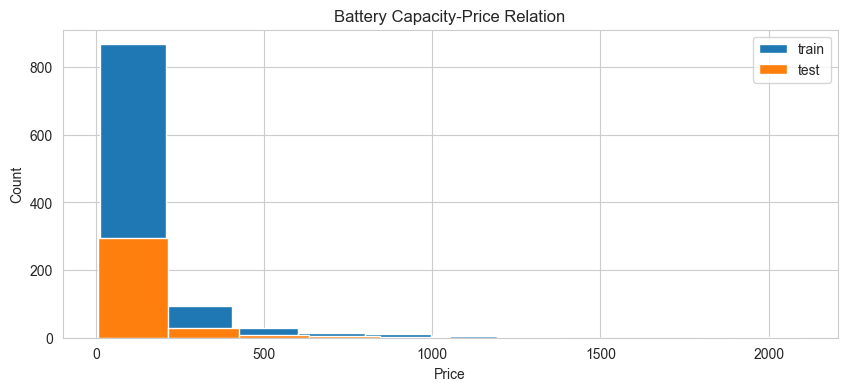

In [12]:
# ensure split representation of the target
fig, ax = plt.subplots(figsize=(10,4))
dtf_train['Price'].hist(ax=ax)
dtf_test['Price'].hist(ax=ax)
ax.legend(["train", "test"])
ax.set_title("Price Histogram")
ax.set_xlabel("Price")
ax.set_ylabel("Count")
ax.set_title("Battery Capacity-Price Relation")

In [13]:
display(dtf_train.isna().sum())
display(dtf_test.isna().sum())

Name                      0
Brand                     0
Model                     0
Battery capacity (mAh)    0
Screen size (inches)      0
Touchscreen               0
Resolution x              0
Resolution y              0
Processor                 0
RAM (MB)                  0
Internal storage (GB)     0
Rear camera               0
Front camera              0
Operating system          0
Wi-Fi                     0
Bluetooth                 0
GPS                       0
Number of SIMs            0
3G                        0
4G/ LTE                   0
Price                     0
dtype: int64

Name                      0
Brand                     0
Model                     0
Battery capacity (mAh)    0
Screen size (inches)      0
Touchscreen               0
Resolution x              0
Resolution y              0
Processor                 0
RAM (MB)                  0
Internal storage (GB)     0
Rear camera               0
Front camera              0
Operating system          0
Wi-Fi                     0
Bluetooth                 0
GPS                       0
Number of SIMs            0
3G                        0
4G/ LTE                   0
Price                     0
dtype: int64

### Categorical Features

In [14]:
categoricall_features = ['Operating system','Brand']

In [15]:
# dummify Operating System
dtf_train = pd.concat([dtf_train, pd.get_dummies(dtf_train['Operating system'], prefix='Operating system',dtype='int64')], axis=1) # changed  to 0/1 insted of boolean  (as was in part 1)
dtf_test = pd.concat([dtf_test, pd.get_dummies(dtf_test['Operating system'], prefix='Operating system',dtype='int64')], axis=1) # changed  to 0/1 insted of boolean  (as was in part 1)

# ensuring each subset has all the dummify columns
for x in dtf['Operating system'].unique():
    if f'Operating system_{x}' not in dtf_train.columns:
        dtf_train[f'Operating system_{x}'] = 0
    if f'Operating system_{x}' not in dtf_test.columns:
        dtf_test[f'Operating system_{x}'] = 0        

dtf_train = dtf_train.drop('Operating system', axis=1)
dtf_test = dtf_test.drop('Operating system', axis=1)

In [16]:
# Brand
dtf_train['Brand'].value_counts()[0:10]

Brand
Intex        93
Samsung      71
Micromax     49
Lava         42
Panasonic    38
Vivo         38
Motorola     33
Asus         32
LG           31
Karbonn      30
Name: count, dtype: int64

In [17]:
# we will keep brands with at least 35 phones
high_categories = dtf_train['Brand'].value_counts()[dtf_train['Brand'].value_counts() >= 35]
new_col_train = dtf_train['Brand'].apply(lambda x: 'Other' if x not in high_categories else x )
new_col_test = dtf_test['Brand'].apply(lambda x: 'Other' if x not in high_categories else x )

In [18]:
dummy_train = pd.get_dummies(new_col_train, prefix="Brand",dtype='int64') # changed to 0/1 insted of boolean (as was in part 1)
dummy_test = pd.get_dummies(new_col_test, prefix="Brand",dtype='int64')  # changed  to 0/1 insted of boolean  (as was in part 1)

In [19]:
dtf_train = pd.concat([dtf_train, dummy_train], axis=1)
dtf_test = pd.concat([dtf_test, dummy_test], axis=1)

In [20]:
X_train = dtf_train.drop(['Brand','Name','Model','Price'],axis=1)
X_test = dtf_test.drop(['Brand','Name','Model','Price'],axis=1)

y_train = dtf_train['Price']
y_test = dtf_test['Price']

In [21]:
features_model = X_train.columns

In [22]:
basic_model = xgboost.XGBRegressor()
basic_model.fit(X_train[features_model],y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
basic_model_prediction = basic_model.predict(X_test[features_model])

In [24]:
# metrics

basic_model_r2 = r2_score(y_test,basic_model_prediction)
print(f'r^2 score: {basic_model_r2}')

basic_model_adjusted_r2 = 1 - ((1 - basic_model_r2) * (len(X_test) - 1) /
                               (len(X_test) - len(features_model) - 1))
print(f'adjusted r^2 score: {basic_model_adjusted_r2}')

print("Mean Absolute Perc Error (Σ(|y - pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test,basic_model_prediction)))
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, basic_model_prediction)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, basic_model_prediction))))

# residuals
residuals = y_test - basic_model_prediction
max_error = residuals.abs().max()
print("Max Error:", "{:,.0f}".format(max_error))

results_dtf.loc[len(results_dtf)] = ['baseline',
                                     basic_model_r2,
                                     basic_model_adjusted_r2,
                                     mean_absolute_percentage_error(y_test,basic_model_prediction),
                                     mean_absolute_error(y_test, basic_model_prediction),
                                     np.sqrt(mean_squared_error(y_test, basic_model_prediction)),
                                     max_error]


r^2 score: 0.5226881595128583
adjusted r^2 score: 0.47634720412575715
Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 0.478
Mean Absolute Error (Σ|y - pred|/n): 55
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 119
Max Error: 1,391


## Improvement #1 - Correlated Features

## Dummies linear dependency

Removing linear dependency from dummy variables - in the baseline model we created a new column for each class but we can remove the 'default' class because we know that it will get a value of 1 when all the sum of all the other class are 0.

In [25]:
print('Example (the Android value can be inffered from all other classes):')
X_train.loc[X_train['Operating system_Android']==1][[x for x in X_train.columns if 'Operating system' in x]].iloc[0]

Example (the Android value can be inffered from all other classes):


Operating system_Android       1
Operating system_BlackBerry    0
Operating system_Cyanogen      0
Operating system_Sailfish      0
Operating system_Tizen         0
Operating system_Windows       0
Operating system_iOS           0
Name: 341, dtype: int64

In [26]:
# Android will be our default OS since it has the most samples
X_train = X_train.drop(columns='Operating system_Android')
X_test = X_test.drop(columns='Operating system_Android')

In [27]:
# Other will be our default brand since it has the most samples
X_train = X_train.drop(columns='Brand_Other')
X_test = X_test.drop(columns='Brand_Other')

## Variance Inflation Factor

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [29]:
numeric_features = [x for x in X_train.columns if X_train[x].dtype == 'int64' or X_train[x].dtype == 'float64']

In [30]:
# adding intercept value
X_train_with_intercept = np.column_stack((np.ones(X_train.shape[0]), X_train[numeric_features].values))
vif_all_numeric_dtf = pd.DataFrame()
vif_all_numeric_dtf['Feature'] = ['intercept'] + numeric_features
vif_all_numeric_dtf['VIF'] = [variance_inflation_factor(X_train_with_intercept, i) for i in range(X_train_with_intercept.shape[1])]
vif_all_numeric_dtf.sort_values('VIF',ascending=False)

,Feature,VIF
0,intercept,457.566867
5,Resolution y,10.529423
4,Resolution x,7.187723
7,RAM (MB),6.363065
2,Screen size (inches),3.837267
8,Internal storage (GB),3.827096
10,Front camera,2.642958
1,Battery capacity (mAh),2.480157
9,Rear camera,2.201582
6,Processor,2.122820


'Resolution y' has a high VIF value (>10) and therefore should be removed from our model (the feature has multicollinearity with the other features).

In [31]:
X_train = X_train.drop(columns='Resolution y')
X_test = X_test.drop(columns='Resolution y')

## Re-Training

In [32]:
features_model_1 = X_train.columns

In [33]:
improved_model = xgboost.XGBRegressor()
improved_model.fit(X_train[features_model_1],y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
improved_model_prediction = improved_model.predict(X_test[features_model_1])

In [35]:
# metrics

improved_model_r2 = r2_score(y_test,improved_model_prediction)
print(f'r^2 score: {improved_model_r2}')

improved_model_adjusted_r2 = 1 - ((1 - improved_model_r2) * (len(X_test) - 1) / (len(X_test) - X_test.shape[1] - 1))
print(f'adjusted r^2 score: {improved_model_adjusted_r2}')

print("Mean Absolute Perc Error (Σ(|y - pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test,improved_model_prediction)))
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, improved_model_prediction)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, improved_model_prediction))))

# residuals
residuals = y_test - improved_model_prediction
max_error = residuals.abs().max()
print("Max Error:", "{:,.0f}".format(max_error))

results_dtf.loc[len(results_dtf)] = ['improved_model_1_after_removing_colinearity',
                                     improved_model_r2,
                                     improved_model_adjusted_r2,
                                     mean_absolute_percentage_error(y_test,improved_model_prediction),
                                     mean_absolute_error(y_test, improved_model_prediction),
                                     np.sqrt(mean_squared_error(y_test, improved_model_prediction)),
                                     max_error]

r^2 score: 0.5196288409054861
adjusted r^2 score: 0.4780582598299993
Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 0.452
Mean Absolute Error (Σ|y - pred|/n): 53
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 119
Max Error: 1,418


In [36]:
results_dtf

,model,r2,adj_r2,Mean Absolute Perc Error,Mean Absolute Error,Root Mean Squared Error,Max Error
0,baseline,0.522688,0.476347,0.478262,55.386207,118.986865,1390.839412
1,improved_model_1_after_removing_colinearity,0.519629,0.478058,0.452342,53.110486,119.367577,1417.540583


## Improvement #2 - Feature Engineering

## Battery Capacity Binning

In [37]:
# based on the graph in the first section, we will split the battery capacity to 3 different features (bins):
# X<3861, 3861<X<5287, X>5287

X_train['dtf_battery_price_binned'] = pd.cut(X_train['Battery capacity (mAh)'], bins=[0,3861,5287,np.inf])
X_train = pd.get_dummies(X_train, columns=['dtf_battery_price_binned'], drop_first=True,dtype='int64')

X_test['dtf_battery_price_binned'] = pd.cut(X_test['Battery capacity (mAh)'], bins=[0,3861,5287,np.inf])
X_test = pd.get_dummies(X_test, columns=['dtf_battery_price_binned'], drop_first=True,dtype='int64')

In [38]:
# Example
X_train[[x for x in X_train.columns if 'battery' in x or 'Battery' in x]].head(5)

,Battery capacity (mAh),"dtf_battery_price_binned_(3861.0, 5287.0]","dtf_battery_price_binned_(5287.0, inf]"
341,2700,0,0
567,2000,0,0
769,3930,1,0
1269,2000,0,0
1139,3000,0,0


## RAM (MB) Dummies

In [39]:
dtf['RAM (MB)'].value_counts()

RAM (MB)
1000     353
2000     342
3000     282
4000     200
512       72
6000      63
8000      29
256        8
12000      4
64         2
768        2
384        1
289        1
Name: count, dtype: int64

We can see that even though RAM is a numeric feature it does have a small number of discrete options - therefore we will treat it as a categorical feature and dummify it (the difference between 2000 to 4000 MB isn't necessary the same as the difference between 4000 to 6000 even though they are both have a difference of 2000).  
In addition we will group all the small values (below 1000) to the 512 MB group.

In [40]:
X_train['RAM (MB)'] = X_train['RAM (MB)'].apply(lambda x: 512 if x < 1000 else x)
X_test['RAM (MB)'] = X_test['RAM (MB)'].apply(lambda x: 512 if x < 1000 else x)

In [41]:
X_train = pd.get_dummies(X_train, columns=['RAM (MB)'], drop_first=True,dtype='int64')
X_test = pd.get_dummies(X_test, columns=['RAM (MB)'], drop_first=True,dtype='int64')

# ensuring each subset has all the dummify columns
for x in dtf['RAM (MB)'].unique():
    if f'RAM (MB)_{x}' not in X_train.columns:
        X_train[f'RAM (MB)_{x}'] = 0
    if f'RAM (MB)_{x}' not in X_test.columns:
        X_test[f'RAM (MB)_{x}'] = 0 

## Removing Redundant Features

Text(0.5, 1.0, 'Target Boxplot by OS')

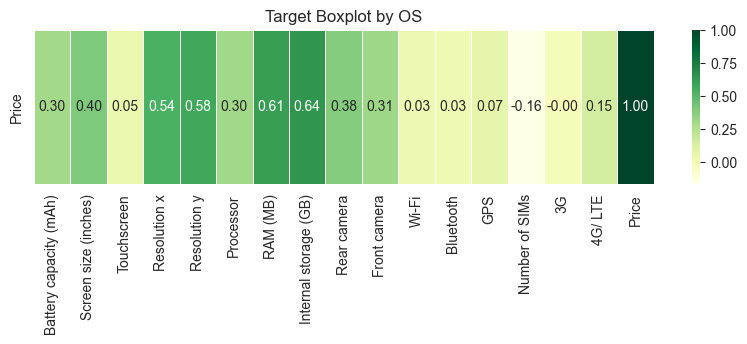

In [42]:
dtf_corr = dtf[numeric_cols].corr(method="pearson").loc[["Price"]]
fig, ax = plt.subplots(figsize=(10,2))
sns.heatmap(dtf_corr, annot=True, fmt='.2f',cmap='YlGn', cbar=True, linewidths=0.5,ax=ax).set_title("Target Boxplot by OS")

As we can see, the following features have near zero correlation with the target and can be removed from the model (they doesn't have much of effect on the price):  
1. 'Wi-Fi'  
2. 'Bluetooth'  
3. 'GPS'  
4. 'Number of SIMs'  
5. '3G'  
6. '4G/ LTE'  

Note: These features are all binary so there isn't much feature engineering that can be done and therefore we'll just remove them.

In [43]:
X_train = X_train.drop(columns=['Wi-Fi', 'Bluetooth', 'GPS', 'Number of SIMs', '3G','4G/ LTE'])
X_test = X_test.drop(columns=['Wi-Fi', 'Bluetooth', 'GPS', 'Number of SIMs', '3G','4G/ LTE'])

## Re-Train

In [44]:
features_model_2 = X_train.columns

In [45]:
improved_model_2 = xgboost.XGBRegressor()
improved_model_2.fit(X_train[features_model_2].values,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
improved_model_2_prediction = improved_model_2.predict(X_test[features_model_2].values)

In [47]:
# metrics

improved_model_2_r2 = r2_score(y_test,improved_model_2_prediction)
print(f'r^2 score: {improved_model_2_r2}')

improved_model_2_adjusted_r2 = 1 - ((1 - improved_model_2_r2) * (len(X_test) - 1) / (len(X_test) - X_test.shape[1] - 1))
print(f'adjusted r^2 score: {improved_model_2_adjusted_r2}')

print("Mean Absolute Perc Error (Σ(|y - pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test,improved_model_2_prediction)))
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, improved_model_2_prediction)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, improved_model_2_prediction))))

# residuals
residuals = y_test - improved_model_2_prediction
max_error = residuals.abs().max()
print("Max Error:", "{:,.0f}".format(max_error))

results_dtf.loc[len(results_dtf)] = ['improved_model_2_after_feature_engineering',
                                     improved_model_2_r2,
                                     improved_model_2_adjusted_r2,
                                     mean_absolute_percentage_error(y_test,improved_model_2_prediction),
                                     mean_absolute_error(y_test, improved_model_2_prediction),
                                     np.sqrt(mean_squared_error(y_test, improved_model_2_prediction)),
                                     max_error]

r^2 score: 0.5430389936226967
adjusted r^2 score: 0.4904283514410993
Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 0.453
Mean Absolute Error (Σ|y - pred|/n): 53
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 116
Max Error: 1,353


In [48]:
results_dtf

,model,r2,adj_r2,Mean Absolute Perc Error,Mean Absolute Error,Root Mean Squared Error,Max Error
0,baseline,0.522688,0.476347,0.478262,55.386207,118.986865,1390.839412
1,improved_model_1_after_removing_colinearity,0.519629,0.478058,0.452342,53.110486,119.367577,1417.540583
2,improved_model_2_after_feature_engineering,0.543039,0.490428,0.452509,53.377470,116.422652,1352.705073


## Improvement #3 - Hyper Parameter GridSearch

In [49]:
from sklearn.model_selection import GridSearchCV

Marked as comment due to long run time

In [50]:
# xgb_regressor = xgb.XGBRegressor(device='cuda')

# # Define the hyperparameters to tune
# param_grid = {
#     'n_estimators': [50,100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 4, 5],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_alpha': [0, 0.1],
#     'reg_lambda': [0, 0.1]
# }

# grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, 
#                            scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
# grid_search.fit(X_train[features_model_2].values, y_train)

# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best parameters:", best_params)
# '''
# {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 1.0}
# '''
# print("Best score:", best_score)
# '''
# Best score: -11225.536755203144
# '''
# # Predict with the best model
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # Calculate and print the RMSE
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"Root Mean Squared Error (RMSE): {rmse}")
# '''
# Root Mean Squared Error (RMSE): 108.50770925736586
# '''

Best hyper-parameters found are:  
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 1.0}

In [51]:
# r2_score(y_test,best_model.predict(X_test))
'''
0.6030595508455745
'''

'\n0.6030595508455745\n'

## Re-Train

In [52]:
features_model_3 = X_train.columns

In [53]:
improved_model_3 = xgboost.XGBRegressor(colsample_bytree = 0.8,
                                        gamma = 0,
                                        learning_rate = 0.1,
                                        max_depth = 3,
                                        n_estimators = 50,
                                        reg_alpha = 0,
                                        reg_lambda = 0.1,
                                        subsample = 1.0)
improved_model_3.fit(X_train[features_model_3].values,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [54]:
improved_model_3_prediction = improved_model_3.predict(X_test[features_model_3].values)

In [55]:
# metrics

improved_model_3_r2 = r2_score(y_test,improved_model_3_prediction)
print(f'r^2 score: {improved_model_3_r2}')

improved_model_3_adjusted_r2 = 1 - ((1 - improved_model_3_r2) * (len(X_test) - 1) / (len(X_test) - X_test.shape[1] - 1))
print(f'adjusted r^2 score: {improved_model_3_adjusted_r2}')

print("Mean Absolute Perc Error (Σ(|y - pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test,improved_model_3_prediction)))
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, improved_model_3_prediction)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, improved_model_3_prediction))))

# residuals
residuals = y_test - improved_model_3_prediction
max_error = residuals.abs().max()
print("Max Error:", "{:,.0f}".format(max_error))

results_dtf.loc[len(results_dtf)] = ['improved_model_3_after_hyper_parameters_tuning',
                                     improved_model_3_r2,
                                     improved_model_3_adjusted_r2,
                                     mean_absolute_percentage_error(y_test,improved_model_3_prediction),
                                     mean_absolute_error(y_test, improved_model_3_prediction),
                                     np.sqrt(mean_squared_error(y_test, improved_model_3_prediction)),
                                     max_error]

r^2 score: 0.5903158387104359
adjusted r^2 score: 0.5431482543514401
Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 0.467
Mean Absolute Error (Σ|y - pred|/n): 51
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 110
Max Error: 1,360


In [56]:
results_dtf

,model,r2,adj_r2,Mean Absolute Perc Error,Mean Absolute Error,Root Mean Squared Error,Max Error
0,baseline,0.522688,0.476347,0.478262,55.386207,118.986865,1390.839412
1,improved_model_1_after_removing_colinearity,0.519629,0.478058,0.452342,53.110486,119.367577,1417.540583
2,improved_model_2_after_feature_engineering,0.543039,0.490428,0.452509,53.377470,116.422652,1352.705073
3,improved_model_3_after_hyper_parameters_tuning,0.590316,0.543148,0.466988,50.508879,110.235761,1359.590083


We can see that we have a trade off between our improved model:  
The first improvement has a lower MAPE than the final model while the final model has a better r^2 score than the first improvement.  
Meaning, that we can choose what do we prefer: a model which better "explains" the features or a model which gives a more accurate price. 

In [57]:
final_model = improved_model_3

# 3. Analyzing the Improved Model

## Feature Importance

In [58]:
import shap

In [59]:
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_test)

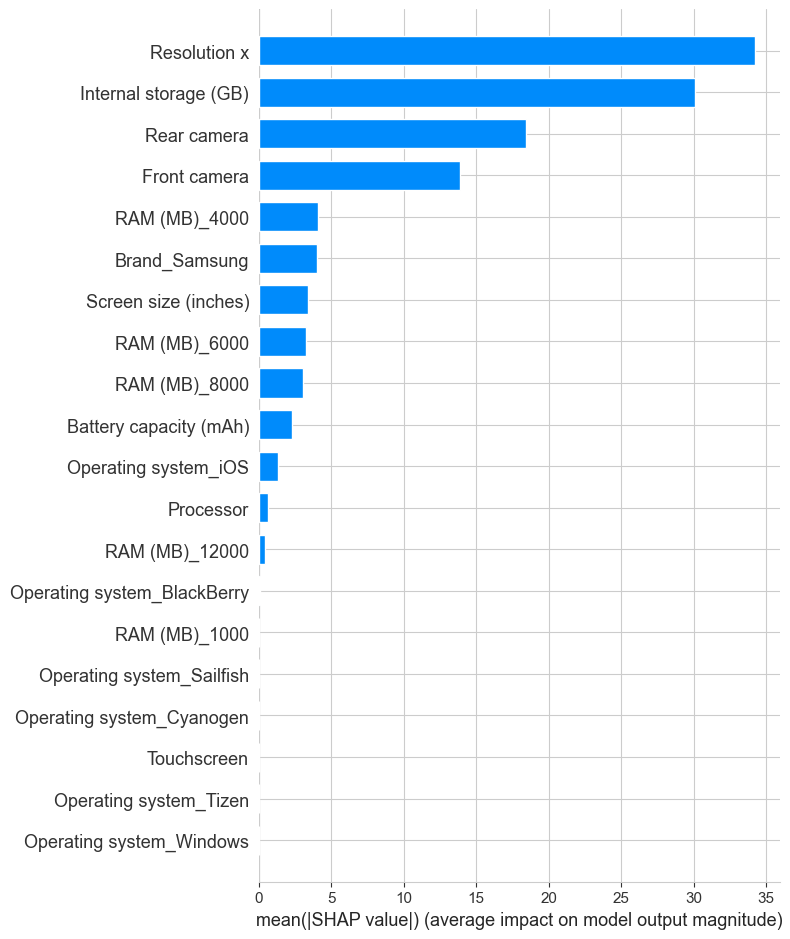

In [60]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

As we can see, the most important features are the hardware features, specifically 'Resolution x','Internal Storage', 'Rear Camera' and 'Front Camera'.  
This follows our intution, that the most dominant factors of a phone price is its hardware - better parts usually makes the phone more expensive.  

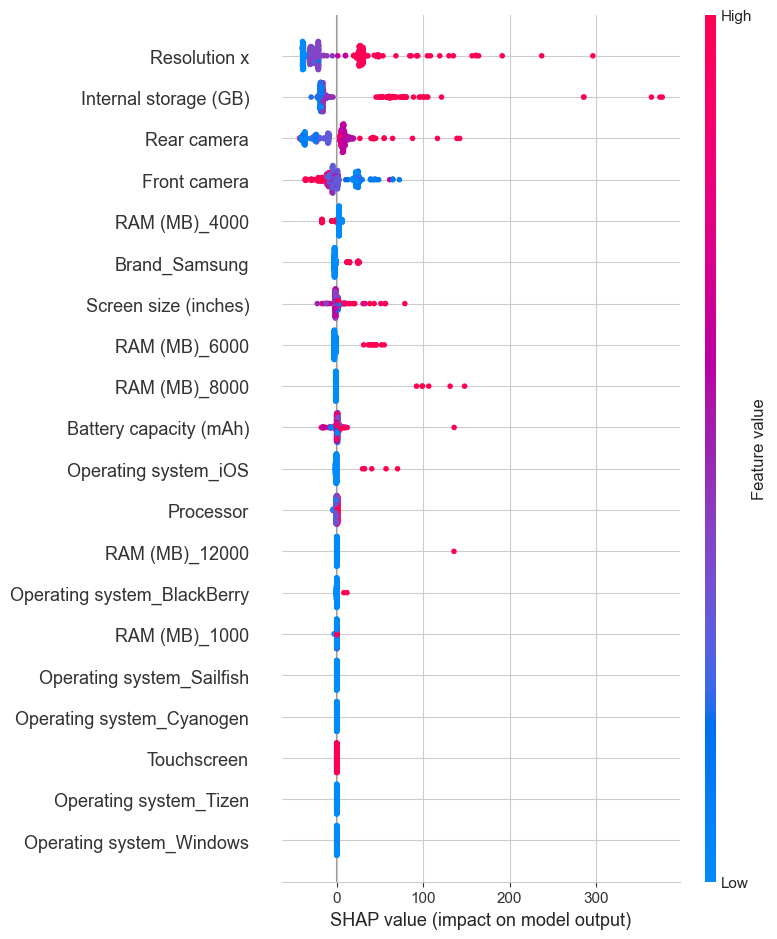

In [61]:
shap.summary_plot(shap_values, X_test)

In this graph we can further support our previous intuition.  
We can see that not only do the hardware features has a big impact on the model output, we can see that higher values (the red parts) do increase the phone price (for example we can see the red dots of 'Resolution x' which are far to the right, meaning that higher resolution increase the price output while the left blue dots means that lower values reduce the output).  
  
Another Interesting fact is that both high and low values of 'Touchscreen' (really 0/1 because Touchscreen is a binary feature) have the same near zero impact on the model, meaning that this is a redundant feature which can be removed.  

## Model Performance

In [62]:
results_dtf[(results_dtf['model']=='baseline') | (results_dtf['model']=='improved_model_3_after_hyper_parameters_tuning')]

,model,r2,adj_r2,Mean Absolute Perc Error,Mean Absolute Error,Root Mean Squared Error,Max Error
0,baseline,0.522688,0.476347,0.478262,55.386207,118.986865,1390.839412
3,improved_model_3_after_hyper_parameters_tuning,0.590316,0.543148,0.466988,50.508879,110.235761,1359.590083


In [63]:
print('Number Of Features:')
print(f'Baseline: {len(features_model)}')
print(f'Final Model: {len(features_model_3)}')

Number Of Features:
Baseline: 30
Final Model: 35


Our final model has improved both r^2 and adjusted r^2 by 7%, MAPE by 1.2%, MAE by 5 USD, RMSE by 8.7 USD and Max Error by 31 USD.  

Meaning, our model gives better price estimation and explains the variance better than the baseline.  
  
In addition, we can see that while we added ~15% more features to our model, we were able keep the adjusted r^2 higher than the baseline. This tells us that the new features we meaningful and helped the model to solve this regression problem better.

## Visualization

In [64]:
improved_model_3_residuals = y_test - improved_model_3_prediction
basic_model_residuals = y_test - basic_model_prediction

Text(0, 0.5, 'Count')

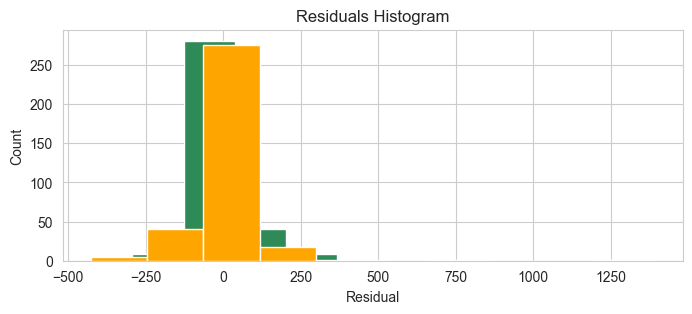

In [65]:
fig, ax = plt.subplots(figsize=(8,3))
improved_model_3_residuals.hist(color='seagreen',ax=ax)
basic_model_residuals.hist(color='orange',ax=ax)
ax.set_title("Residuals Histogram")
ax.set_xlabel("Residual")
ax.set_ylabel("Count")

We can see that the base model was mostly over pricing the phones while our improved model is mostly under pricing the phones.  
However, due to the better metrics we saw (MAPE,MAE etc) we know that the improved model's price is closer to the real world price than the base model.

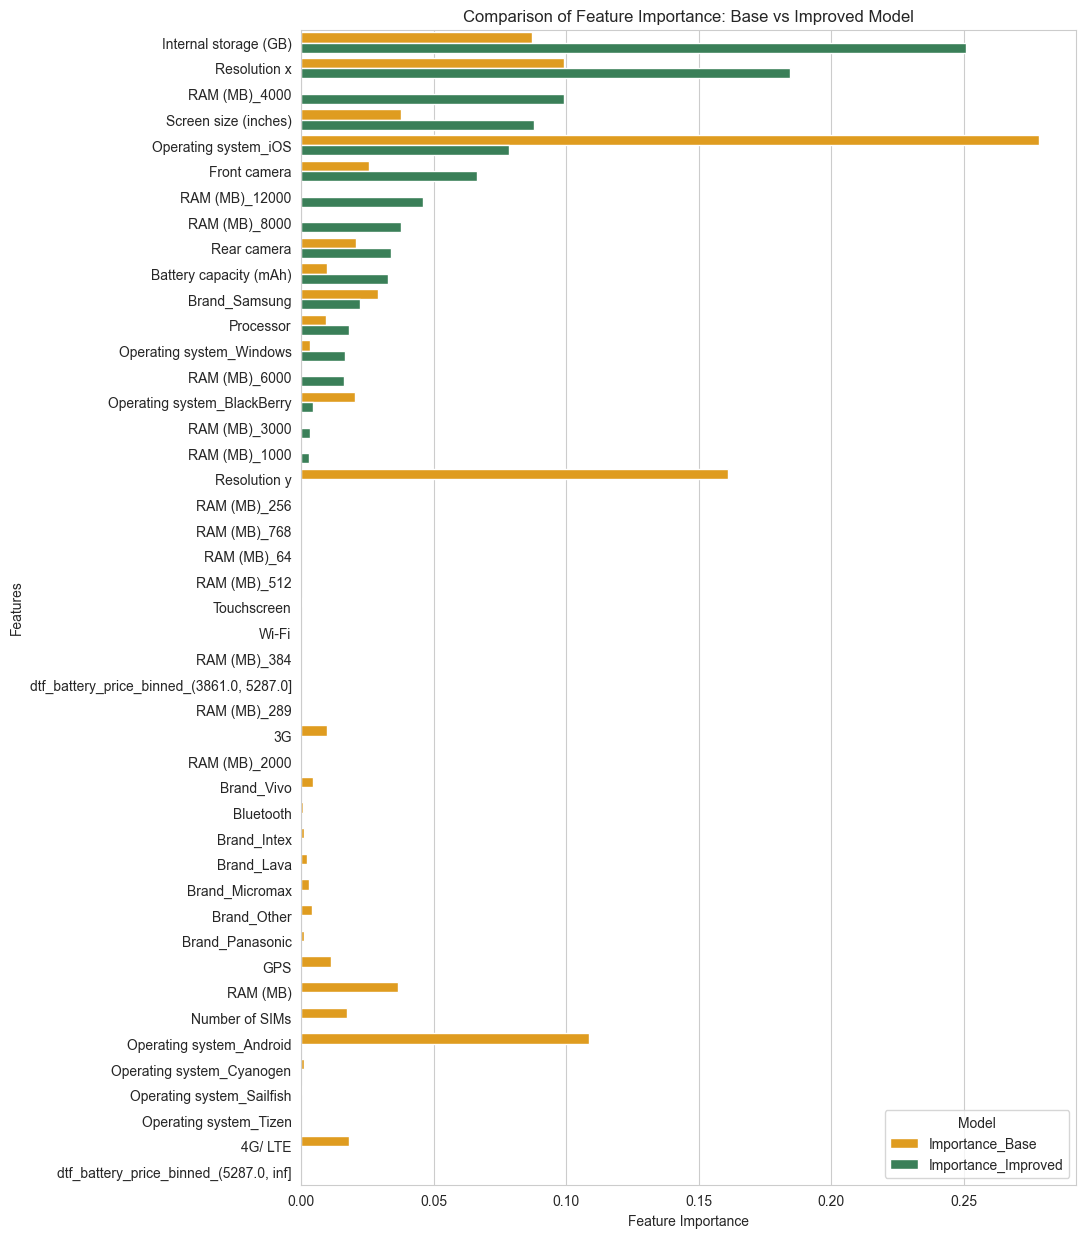

In [66]:
base_importance = pd.DataFrame({
    'Feature': features_model,
    'Importance': basic_model.feature_importances_
})

improved_importance = pd.DataFrame({
    'Feature': features_model_3,
    'Importance': improved_model_3.feature_importances_
})

comparison_df = pd.merge(base_importance, improved_importance, on='Feature', how='outer', suffixes=('_Base', '_Improved')).fillna(0).sort_values(by='Importance_Improved', ascending=False)

plt.figure(figsize=(10, 15))
sns.barplot(data=comparison_df.melt(id_vars="Feature", var_name="Model", value_name="Importance"),
            x="Importance", y="Feature", hue="Model", palette=["orange", "seagreen"])

plt.title("Comparison of Feature Importance: Base vs Improved Model")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.legend(title="Model")

plt.show()


We can learn from this comparison that the base model was mostly dependent on 'Operating System' and 'Resolution y',  
but the improved model has mostly used the new RAM dummies and the 'Internal Storage'.  
Recall that 'Resolution y' was deleted during the colinearity checks and that 'Internal Storage' and 'Resolution y' has a relativly high pearson correlation between them so they do make a reasonable substition for each other.  

# 4. Drawing Conclusions About the Data & Creative Applications

* The improved model has revealed that the most important features are the hardware ones (and specifically RAM) and not the OS/Brand.
* Even though we did improve the model, our scores are still relatively low, meaning that this set of features wasn't enough to estimate the price. This tells us that today we can find the same phone specification (mostly hardware wise) in many different phone tiers.  
* From the fact that the dataset was skewed to the left, we can learn that most (but not limited to) of the phones are low-end ones. However, due to the many outliers we can learn that there are also some very high-end phones on the market.
* A real world usage of this model can be used to predict new phones price based on their specification without the need to wait for the official pricing release - allowing potential buyers to plan their purchase in advance.